<a href="https://colab.research.google.com/github/kirwarobert/cnn/blob/main/SARIMA_ASSIGMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [ ]:
warnings.filterwarnings("ignore")

# Load Airline Passenger Dataset
data = pd.read_csv('/content/AirPassengers.csv', parse_dates=['Month'], index_col='Month')
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [ ]:
print(data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


In [ ]:
print("Missing values detected. Replacing with mean...")
    # Check for Missing Values & Replace with Mean
if data.isnull().sum().any():
    data.fillna(data.mean(), inplace=True)

Missing values detected. Replacing with mean...


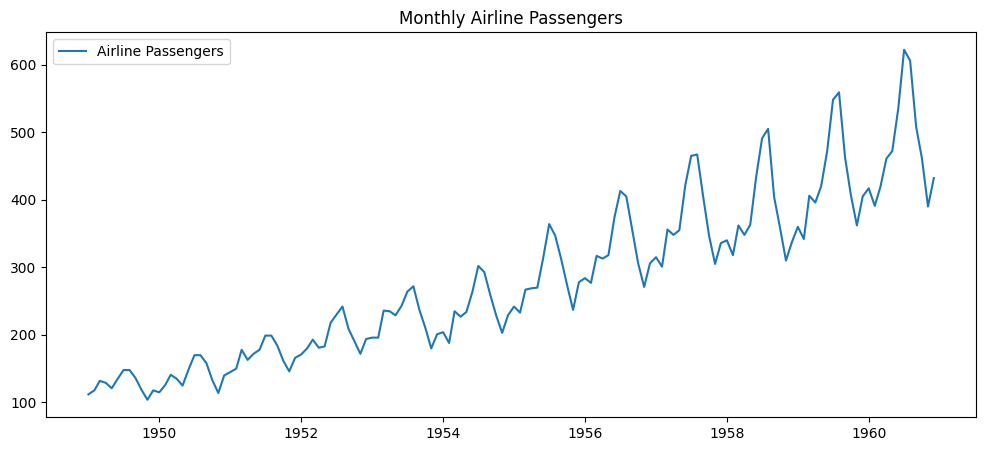

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
plt.plot(data, label='Airline Passengers')
plt.legend()
plt.title('Monthly Airline Passengers')
plt.show()

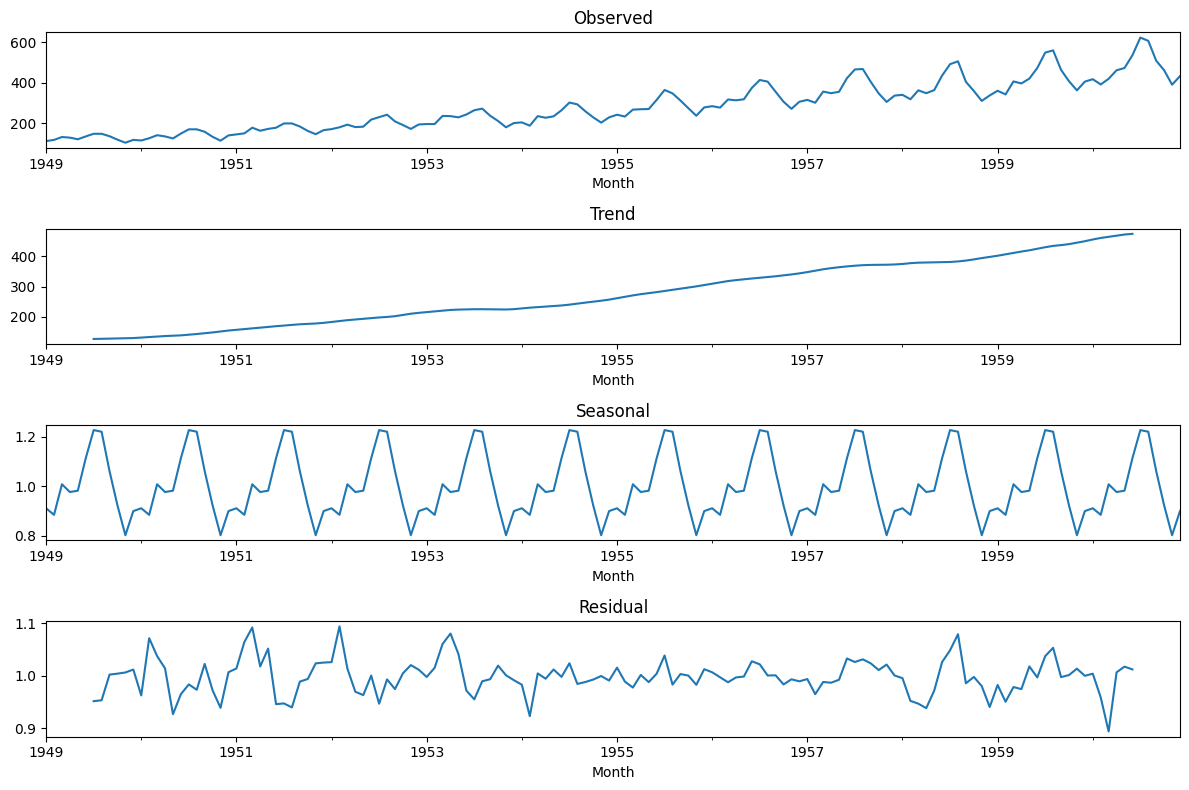

In [ ]:
# Time Series Decomposition
decomposition = seasonal_decompose(data, model='multiplicative', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [ ]:
# Checking Stationarity & Transforming Data
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05

In [ ]:
# Log Transformation to Stabilize Variance
data_log = np.log(data)
if not check_stationarity(data_log):
    print("Data is not stationary after log transformation, applying first-order differencing...")
    data_diff = data_log.diff().dropna()
    if not check_stationarity(data_diff):
        print("Data is still not stationary, applying second-order differencing...")
        data_diff = data_diff.diff().dropna()
else:
    data_diff = data_log

ADF Statistic: -1.7170170891069683
p-value: 0.4223667747703874
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Data is not stationary after log transformation, applying first-order differencing...
ADF Statistic: -2.717130598388114
p-value: 0.07112054815086184
Critical Values:
   1%: -3.4825006939887997
   5%: -2.884397984161377
   10%: -2.578960197753906
Data is still not stationary, applying second-order differencing...


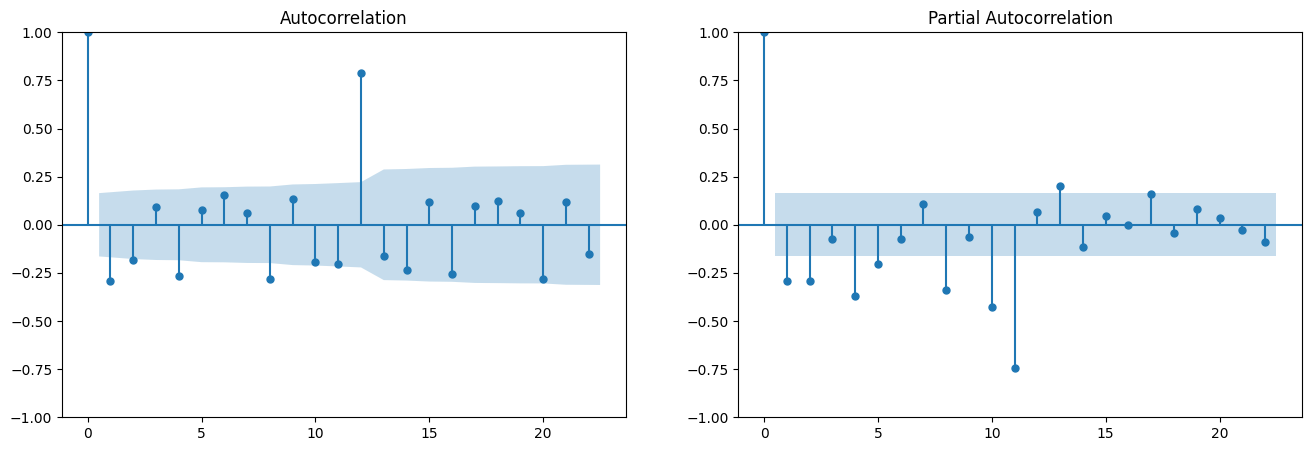

In [ ]:
# Autocorrelation & Partial Autocorrelation Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(data_diff, ax=axes[0])
plot_pacf(data_diff, ax=axes[1])
plt.show()

In [ ]:
# Splitting Data
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
# SARIMA Model Training
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -374.130
Date:                            Tue, 01 Apr 2025   AIC                            758.260
Time:                                    08:25:58   BIC                            771.385
Sample:                                01-01-1949   HQIC                           763.575
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6368      0.334     -1.909      0.056      -1.291       0.017
ma.L1          0.4609      0.372   

In [ ]:
# Model Evaluation
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

MAE: 23.552466101312756, MSE: 908.3542310726416, RMSE: 30.138915559001813


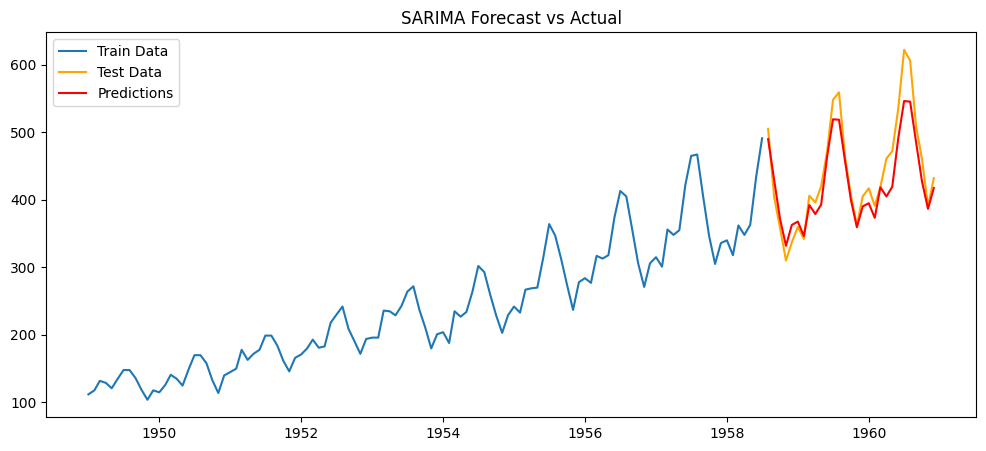

In [ ]:
# Plotting Predictions
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()

In [ ]:
# Forecasting Future Values
future_steps = 12
forecast = model_fit.forecast(steps=future_steps)
print(f'Forecasted Values:\n{forecast}')

Forecasted Values:
1958-08-01    489.724994
1958-09-01    429.407707
1958-10-01    372.218535
1958-11-01    331.839044
1958-12-01    362.702642
1959-01-01    367.722864
1959-02-01    346.380855
1959-03-01    392.243080
1959-04-01    378.881713
1959-05-01    392.927401
1959-06-01    464.529862
1959-07-01    519.095312
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 1
Predicted values for next 1 steps:
1958-08-01    489.724994
Freq: MS, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 3
Predicted values for next 3 steps:
1958-08-01    489.724994
1958-09-01    429.407707
1958-10-01    372.218535
Freq: MS, Name: predicted_mean, dtype: float64
